# K-Nearest Neighbors to predict the Raing of an app based on the user experience

#### Table of Contents

* Setup and Importing data
* Data Cleaning and Feature Engineering 
* Model generation 
* Finding the optimal K-Value 

K-nearest Neighbors is one of the easiest to understand and very effective in the same hand.
> ### "You are who you surround yourself with"


Let's start with a brief introduction to the model again. 

## Introduction 

When KNN is used for classification, the output can be calculated as the class with the highest frequency from the K-most similar instances. Each instance in essence votes for their class and the class with the most votes is taken as the prediction.

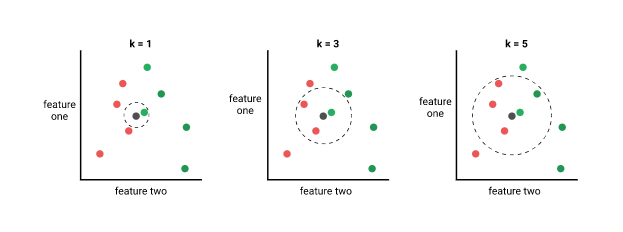

### Distance Measured: 
* Euclidean - The most common one 
* Manhattan
* Minkowski - Default

### Let's get started

#### Setup and importing data 

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#### About the data 

https://www.kaggle.com/lava18/google-play-store-apps

This is a very interesting dataset that I came accross. The Play Store apps data has enormous potential to drive app-making businesses to success. Actionable insights can be drawn for developers to work on and capture the Android market! 


In [ ]:
df = pd.read_csv('googleplaystore.csv')

In [ ]:
#Pre-processing or data cleaning  
df = df[df['Content Rating'] == 'Everyone']
df = df[df['Size'].str[-1] == 'M']
df['Size'] = df['Size'].str[:-1]
grouped = df.groupby('Android Ver')
df = grouped.filter(lambda x: x['Android Ver'].count() > 500)
grouped = df.groupby('Category')
df = grouped.filter(lambda x: x['Category'].count() > 100)
df['Rating'] = df['Rating'].round()
df = df[~df['Installs'].isin(['500,000,000+','50,000,000+','1+','5+','0+','10+','100,000,000+','50+'])]
df['Installs'] = df['Installs'].str[:-1]
df = df[['App','Category','Reviews','Size','Installs','Genres','Android Ver','Rating']]
df['Reviews'] = df['Reviews'].astype(int)
df['Installs'] = df['Installs'].str.replace(',', '').astype(int)
df['Size'] = df['Size'].astype(float)
df.head()

,App,Category,Reviews,Size,Installs,Genres,Android Ver,Rating
140,E-Book Read - Read Book for free,BOOKS_AND_REFERENCE,1857,4.9,50000,Books & Reference,4.4 and up,4.0
147,Free Panda Radio Music,BOOKS_AND_REFERENCE,418,4.2,100000,Books & Reference,4.1 and up,4.0
150,English Grammar Complete Handbook,BOOKS_AND_REFERENCE,1435,2.8,500000,Books & Reference,4.0 and up,5.0
154,Offline English Dictionary,BOOKS_AND_REFERENCE,860,13.0,100000,Books & Reference,4.0.3 and up,4.0
155,Oxford Dictionary of English : Free,BOOKS_AND_REFERENCE,363934,7.1,10000000,Books & Reference,4.1 and up,4.0





### Data Preparation 

Let's start by looking at the data. info() is a great function that shows the basic details of each column available 


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3512 entries, 140 to 10837
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   App          3512 non-null   object 
 1   Category     3512 non-null   object 
 2   Reviews      3512 non-null   int64  
 3   Size         3512 non-null   float64
 4   Installs     3512 non-null   int64  
 5   Genres       3512 non-null   object 
 6   Android Ver  3512 non-null   object 
 7   Rating       3080 non-null   float64
dtypes: float64(2), int64(2), object(4)
memory usage: 246.9+ KB


We know that our y is pricerange. Let's see what are the x variables available: 
* business_id and name are identifiers and hence we donot need them
* Postal_code maybe applicable - It can be used to identify areas that can be in downtown Vs. suburb. Let's hold on to it for now 
* stars, review_count and reservations are definitely x as these independent variables can influence the dependent variable y 

#### Handling NULLs

Since our dataset is fairly big, let's drop the nulls

In [ ]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3080 entries, 140 to 10837
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   App          3080 non-null   object 
 1   Category     3080 non-null   object 
 2   Reviews      3080 non-null   int64  
 3   Size         3080 non-null   float64
 4   Installs     3080 non-null   int64  
 5   Genres       3080 non-null   object 
 6   Android Ver  3080 non-null   object 
 7   Rating       3080 non-null   float64
dtypes: float64(2), int64(2), object(4)
memory usage: 216.6+ KB


We lost about 500 rows.

**Note that there are other ways to handle nulls 

### Feature Analysis

Let's try taking a look at the distribution to see if we can see a clear pattern  

#### Before we start... 

Good news is KNN doesn't take into consideration the distribution. Hence, we don't have to worry if the data is normally distributed. For that reason, it is also sometimes referred to as lazy classification. We can just do some data exploration to confirm that the data quality is high




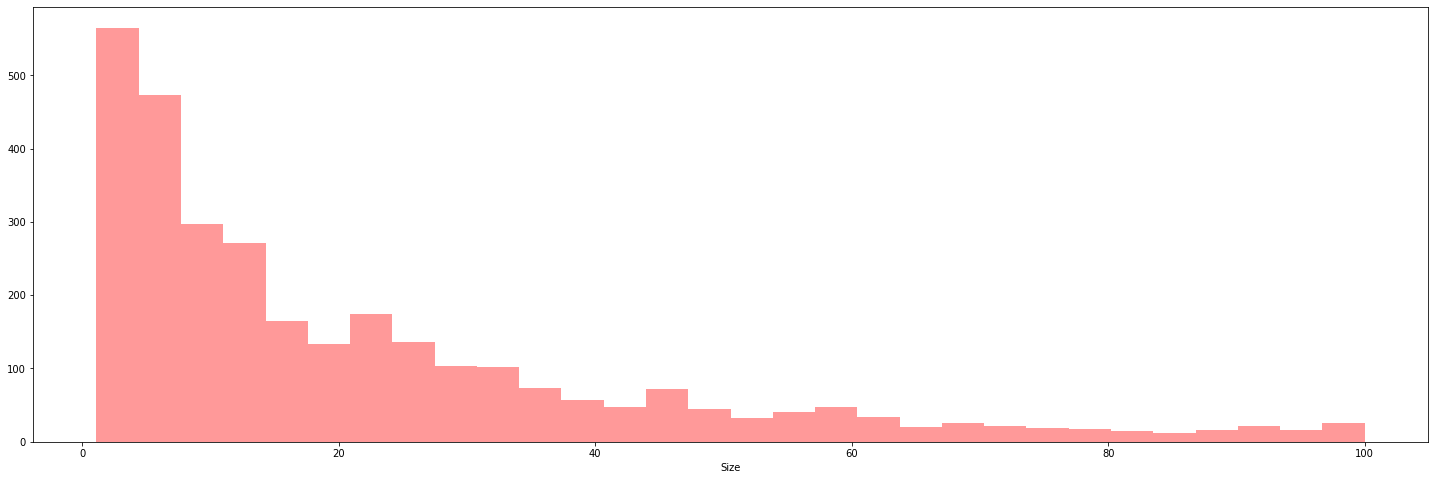

In [ ]:
plt.figure(figsize=(25,8))
sns.distplot(df['Size'], kde = False, color ='red', bins = 30)

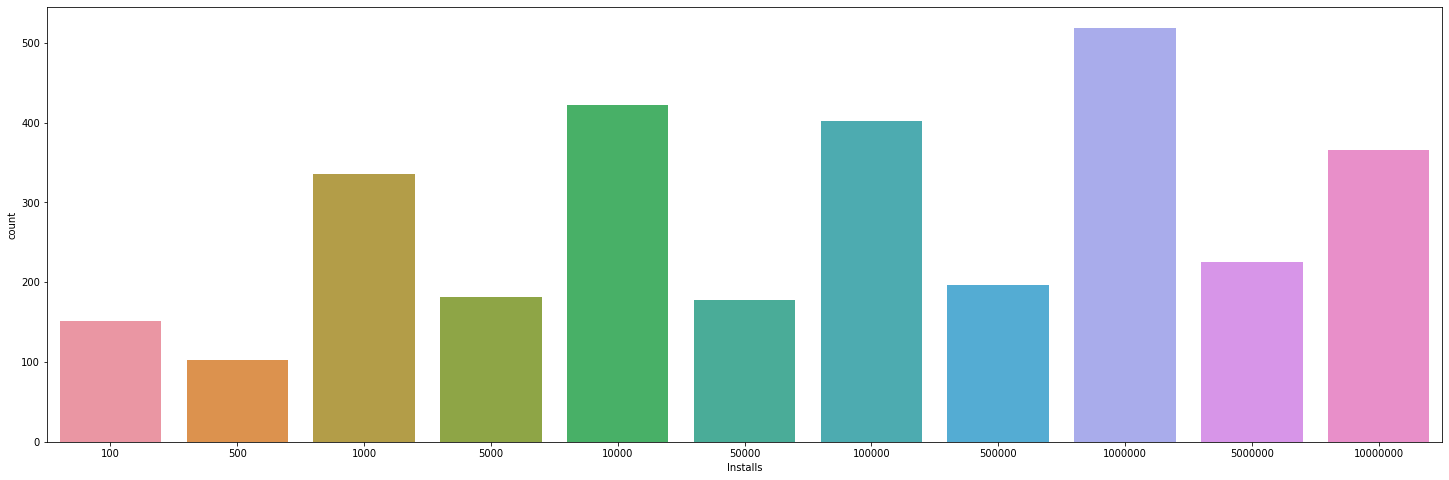

In [ ]:
plt.figure(figsize=(25,8))
# Count Plot (a.k.a. Bar Plot)
sns.countplot(x='Installs', data=df)

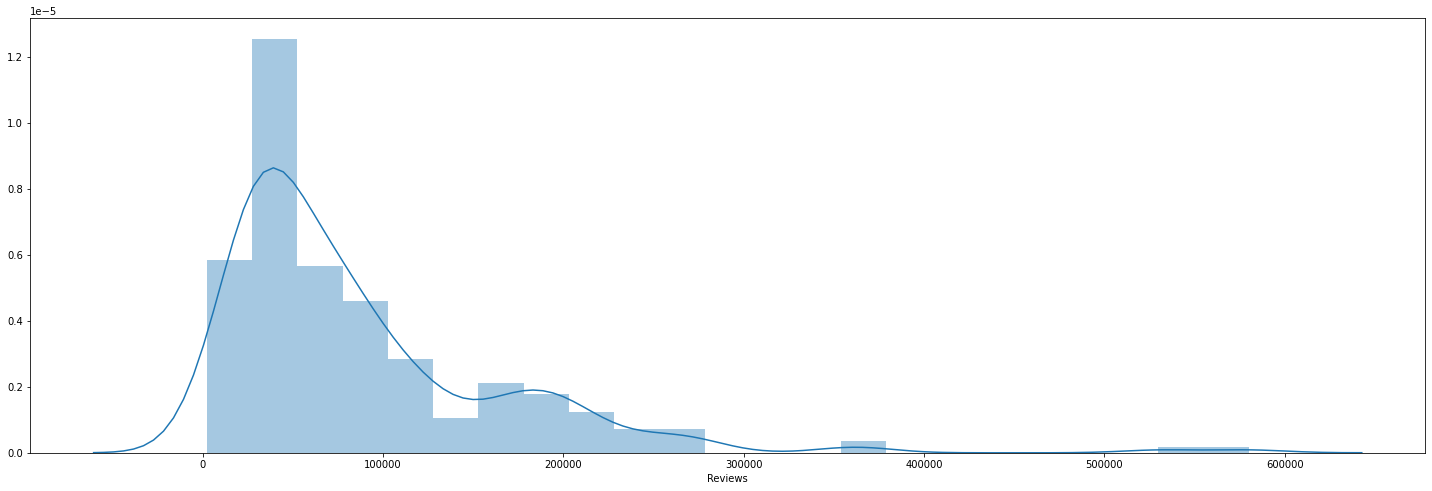

In [ ]:
plt.figure(figsize=(25,8))
sns.distplot(df['Reviews'][df['Installs'] == 5000000])

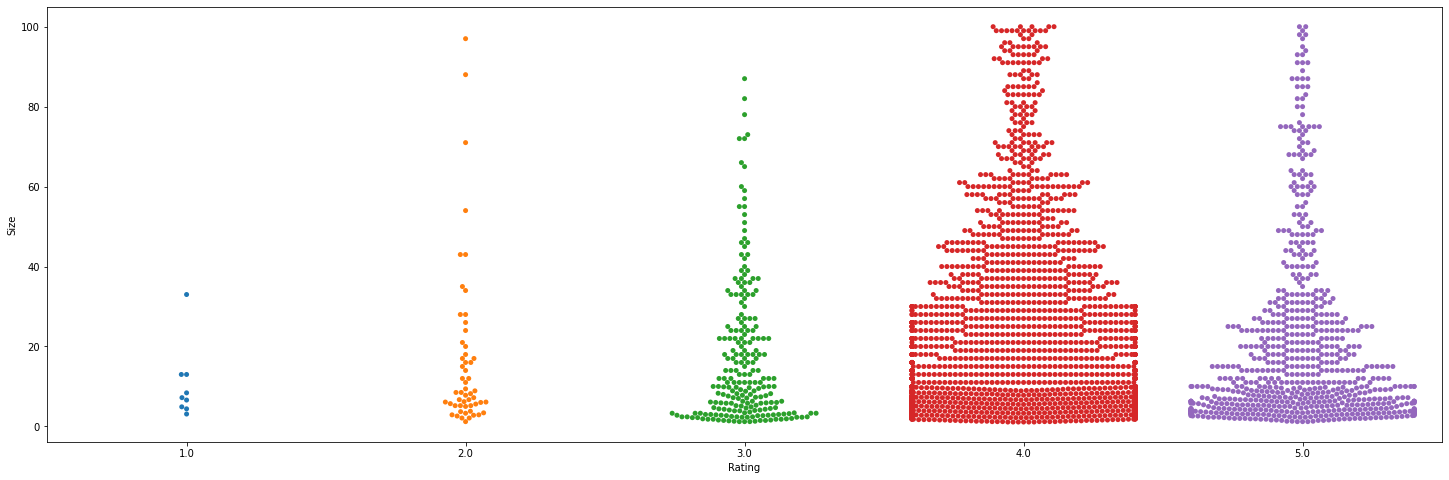

In [ ]:
plt.figure(figsize=(25,8))
sns.swarmplot(x='Rating', y='Size', data=df)

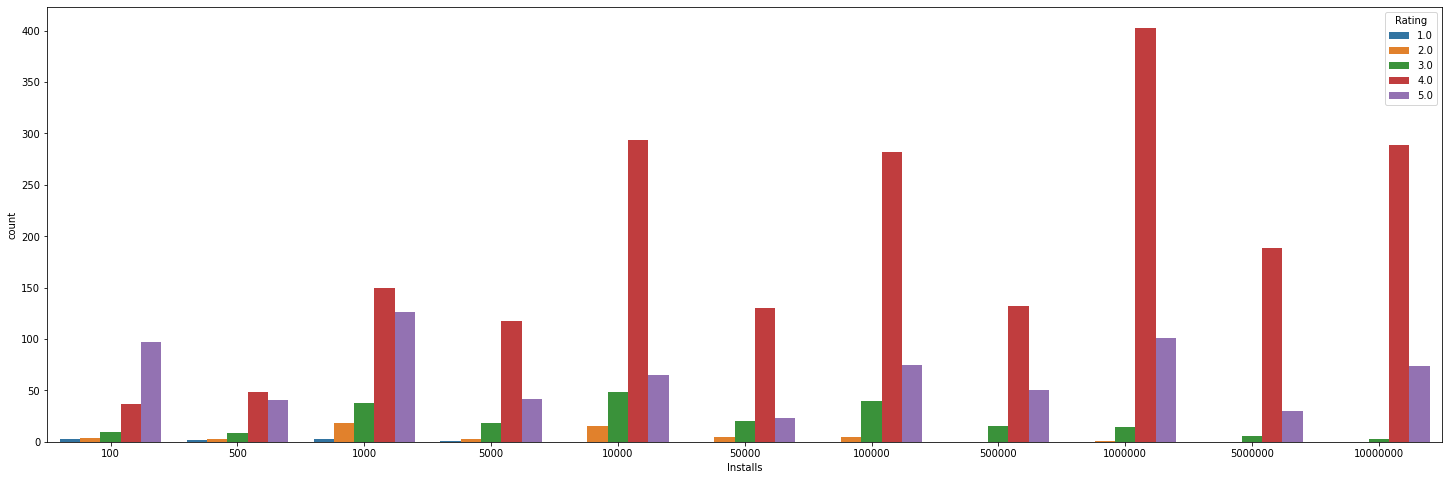

In [ ]:
plt.figure(figsize=(25,8))
# Count Plot (a.k.a. Bar Plot)
sns.countplot(x='Installs',hue='Rating', data=df)

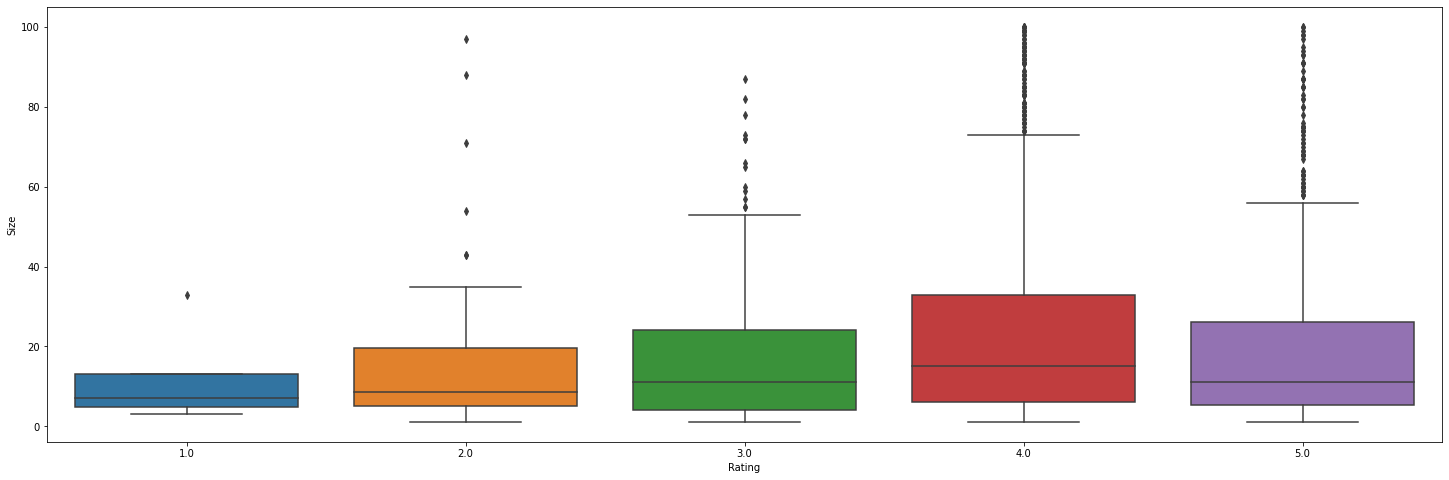

In [ ]:
plt.figure(figsize=(25,8))
sns.boxplot(
    data=df,
    x='Rating',
    y='Size')

### The last step 

Before we create the model, we need to take care of one more thing. KNN does not handle categorical variables. Hence we will use label encoders to change the categorical variables into numerical ones


In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
df.head()

,App,Category,Reviews,Size,Installs,Genres,Android Ver,Rating
140,E-Book Read - Read Book for free,BOOKS_AND_REFERENCE,1857,4.9,50000,Books & Reference,4.4 and up,4.0
147,Free Panda Radio Music,BOOKS_AND_REFERENCE,418,4.2,100000,Books & Reference,4.1 and up,4.0
150,English Grammar Complete Handbook,BOOKS_AND_REFERENCE,1435,2.8,500000,Books & Reference,4.0 and up,5.0
154,Offline English Dictionary,BOOKS_AND_REFERENCE,860,13.0,100000,Books & Reference,4.0.3 and up,4.0
155,Oxford Dictionary of English : Free,BOOKS_AND_REFERENCE,363934,7.1,10000000,Books & Reference,4.1 and up,4.0


In [ ]:
labelencoder_res = LabelEncoder()
df.loc[ : ,'Genres'] = labelencoder_res.fit_transform(df['Genres'])
df.loc[ : ,'Android Ver'] = labelencoder_res.fit_transform(df['Android Ver'])
df.loc[ : ,'Category'] = labelencoder_res.fit_transform(df['Category'])

In [ ]:
df.head()

,App,Category,Reviews,Size,Installs,Genres,Android Ver,Rating
140,E-Book Read - Read Book for free,0,1857,4.9,50000,14,3,4.0
147,Free Panda Radio Music,0,418,4.2,100000,14,2,4.0
150,English Grammar Complete Handbook,0,1435,2.8,500000,14,0,5.0
154,Offline English Dictionary,0,860,13.0,100000,14,1,4.0
155,Oxford Dictionary of English : Free,0,363934,7.1,10000000,14,2,4.0


### Model Training

We have everything ready: 
* Our x is 'Category','Reviews','Size','Genres','Android Ver'
* Our y is 'Rating'


Let's start generating the model by created our x, y arrays. Here we switch from dataframes to array for convenience to feed data into the model 


In [ ]:
x = df[['Category','Reviews','Size','Genres','Android Ver']]
y = df['Rating'].astype(str)

In [ ]:
y.unique()

array(['4.0', '5.0', '3.0', '2.0', '1.0'], dtype=object)

Confirm by looking at their shapes. Usually x and y should contain the same count of dataset and while x can contain more than one column, y usually contains just one

In [ ]:
x.shape

(3080, 5)

In [ ]:
y.shape

(3080,)

#### Using Scikit Learn 

To split our training and test set 

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.20, random_state = 5)

In [ ]:
x_train.shape, x_test.shape

((2464, 5), (616, 5))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [ ]:
classifier = KNeighborsClassifier(n_neighbors = 2)

In [ ]:
classifier.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [ ]:
y_pred = classifier.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_pred,y_test))

Accuracy: 0.5827922077922078


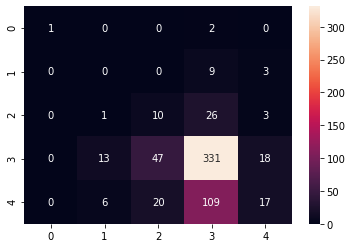

In [ ]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot = True, fmt='g')

### Important metrics that we can calculate

* Precision = true positives / (true positives+false positives)
* recall = true positives / (true positives + false negatives)
* f1 = harmonic mean of precision and recall
* accuracy = true positives + true negatives/ total

The metric I will focus on is accuracy. Because it is a classification model (multi-class), we will focus on this metric. 56% - This is the base but let's try to improve this. 

We know the n_neighbors is a hyperparameter that takes n points into consideration for classification. Finding the optimal K is the first step to optimizing the model. To do that we calculate the error_rate which is the mean when the prediction is not equal to the true value

In [ ]:
accuracy = []
neighbors = list(range(1,30))
train_results = []
test_results = []
for n in neighbors:    
    knn = KNeighborsClassifier (n_neighbors=n)
    knn.fit(x_train,y_train)
    pred_i = knn.predict(x_test)
    accuracy.append(metrics.accuracy_score(pred_i,y_test))

In [ ]:
import plotly.graph_objects as go

x = list(range(1,60))

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x,
    y=accuracy,
    mode='lines+markers'
))
fig.show()

### Plot Interpretation 

From the above graph, we can see that the accuracy is highest when n = 21. Let's run our model again

In [ ]:
classifier = KNeighborsClassifier(n_neighbors = 21)
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_pred,y_test))

Accuracy: 0.6785714285714286


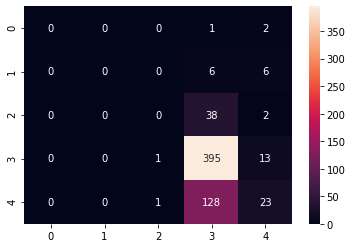

In [ ]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot = True, fmt='g')

Best Hyper Parameters:
 {'algorithm': 'auto', 'leaf_size': 1, 'metric': 'manhattan', 'n_neighbors': 29, 'weights': 'distance'}
Accuracy: 0.6964285714285714


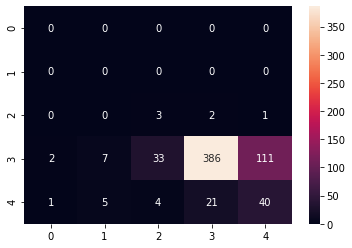

In [ ]:
from sklearn.model_selection import GridSearchCV
#making the instance
model = KNeighborsClassifier(n_jobs=-1)
#Hyper Parameters Set
params = {'n_neighbors':list(range(1,30)),
          'leaf_size':list(range(1,5)),
          'weights':['uniform', 'distance'],
          'metric':['minkowski','manhattan','euclidean'],
          'algorithm':['auto', 'ball_tree','kd_tree','brute']}
#Making models with hyper parameters sets
model1 = GridSearchCV(model, param_grid=params, n_jobs=1)
#Learning
model1.fit(x_train,y_train)
#The best hyper parameters set
print("Best Hyper Parameters:\n",model1.best_params_)
#Prediction
prediction=model1.predict(x_test)
print("Accuracy:",metrics.accuracy_score(prediction,y_test))
#evaluation(Confusion Metrix)
cm = confusion_matrix(prediction, y_test)
sns.heatmap(cm, annot = True, fmt='g')

In [ ]:
print(prediction[:10])
print(y_test[:10].values)

['5.0' '4.0' '4.0' '4.0' '4.0' '5.0' '4.0' '4.0' '4.0' '4.0']
['5.0' '5.0' '5.0' '4.0' '4.0' '4.0' '4.0' '4.0' '5.0' '4.0']


### YES !

There is a 12% increase in the overall score. 

We can significantly improve this score by one of the following methods:
1. Hyperparameter tuning, we currently changed the n to see a 10% increase in the accuracy. How about we change the measure of distance from minkowski to euclidean? Will that impact? what are the other possible parameters available? We now the answers because of grid search  
2. Feature Engineering - Data selection and manipulation. Principal Component Analysis and find that one of your features have very low correlation with the output, then you probably don’t need to be processing it. Some features are going to be intuitively not useful, such as the ID or perhaps recording date. do some data exploration to find out what information and features are actually needed for predictions. Often times, you’ll find that your dataset comes with some extra features that are either redundant or don’t contribute to the prediction at all.
3. Try Other models. Better yet, try combining models: Ensemble Models where you can combine 2 models to predict better. Sumana talked about this in her initial webinar. Link is here: 


### What's next? 

The data I used is a small subset of the features avaialble in the dataset. I urge you to go through the original data and see if you can perform feature analysis on the data to extract other features that can help in determining the Rating of the app 



### Usual Practice datasets: 
* Iris dataset: https://www.kaggle.com/uciml/iris 
* MNIST dataset: https://www.kaggle.com/c/digit-recognizer/data
